In [1]:
import os.path
import urllib.request
import gzip
import shutil

if not os.path.exists('winequality-red.csv'):
    urllib.request.urlretrieve('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', 'winequality-red.csv')
if not os.path.exists('winequality-white.csv'):
    urllib.request.urlretrieve('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv', 'winequality-white.csv')
if not os.path.exists('winequality.names'):
    urllib.request.urlretrieve('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality.names', 'winequality.names')


In [2]:
%matplotlib inline
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

spark = SparkSession.builder.appName('wine-quality').getOrCreate()

In [3]:
red = spark.read.option("delimiter", ";").csv('./winequality-red.csv', header='true', inferSchema='true')
# white = spark.read.option("delimiter", ";").csv('./winequality-white.csv', header='true', inferSchema='true')

red.printSchema()
display(red.limit(20).toPandas())
red.count()

root
 |-- fixed acidity: double (nullable = true)
 |-- volatile acidity: double (nullable = true)
 |-- citric acid: double (nullable = true)
 |-- residual sugar: double (nullable = true)
 |-- chlorides: double (nullable = true)
 |-- free sulfur dioxide: double (nullable = true)
 |-- total sulfur dioxide: double (nullable = true)
 |-- density: double (nullable = true)
 |-- pH: double (nullable = true)
 |-- sulphates: double (nullable = true)
 |-- alcohol: double (nullable = true)
 |-- quality: integer (nullable = true)



,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
5,7.4,0.660,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5
6,7.9,0.600,0.06,1.6,0.069,15.0,59.0,0.9964,3.30,0.46,9.4,5
7,7.3,0.650,0.00,1.2,0.065,15.0,21.0,0.9946,3.39,0.47,10.0,7
8,7.8,0.580,0.02,2.0,0.073,9.0,18.0,0.9968,3.36,0.57,9.5,7
9,7.5,0.500,0.36,6.1,0.071,17.0,102.0,0.9978,3.35,0.80,10.5,5


1599

In [4]:
train, test = red.randomSplit([0.8, 0.2])
train.count()
test.count()

338

# Exploratory Data Analysis

In [5]:
from pyspark.sql.functions import kurtosis, skewness

labelCol = 'quality'

display(train.select(labelCol).describe().toPandas())
display(train.groupby(labelCol).count().orderBy(labelCol).toPandas())
display(train.agg(skewness(labelCol)).toPandas())
display(train.agg(kurtosis(labelCol)).toPandas())

# Last parameter is error tolerance
quantile = train.approxQuantile(labelCol, [0.25, 0.50, 0.75], 0.05)
quantileFrame = spark.createDataFrame([quantile], ['25%', '50%', '75%'])
display(quantileFrame.toPandas())
train.stat.freqItems([labelCol], 0.1).toPandas()

,summary,quality
0,count,1261
1,mean,5.6193497224425055
2,stddev,0.8014311934008284
3,min,3
4,max,8


,quality,count
0,3,7
1,4,42
2,5,552
3,6,499
4,7,145
5,8,16


,skewness(quality)
0,0.292623


,kurtosis(quality)
0,0.370935


,25%,50%,75%
0,5.0,6.0,6.0


,quality_freqItems
0,"[8, 5, 4, 7, 3, 6]"


The distribution of class has small positive skewness and kurtosis. So we can conclude it follows normal distribution roughly. 

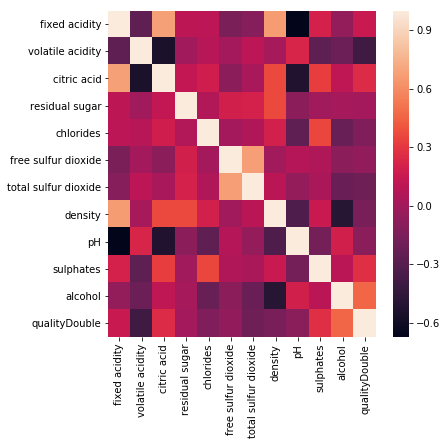

In [6]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

changedTrain = train.withColumn(labelCol+'Double', train[labelCol].cast("double")).drop(labelCol)

numericCols = changedTrain.columns

corrAssembler = VectorAssembler(inputCols=numericCols, outputCol='corrFeatures')
corrTrain = corrAssembler.transform(changedTrain)
corrMat = Correlation.corr(corrTrain, 'corrFeatures').head()

pdf = corrMat[0].toArray()

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))

sns.heatmap(pdf, 
            xticklabels=numericCols,
            yticklabels=numericCols)

There's some moderate positive correlation between 'citric acid' and 'fixed acidity', 'free sulfur dioxide' and 'total sulfur dioxide', 'fixed acidity' and 'density'

In [7]:
from pyspark.sql.functions import stddev_pop, var_pop

cols = train.columns[:]
cols.remove(labelCol)

stddev_pops = [stddev_pop(column).alias(column) for column in cols]
var_pops = [var_pop(column).alias(column) for column in cols]

df1 = train.agg(*stddev_pops)
df2 = train.agg(*var_pops)
df1.show(truncate=True, vertical=True)
df2.show(truncate=True, vertical=True)

-RECORD 0------------------------------------
 fixed acidity        | 1.7339054079326566   
 volatile acidity     | 0.18387071977423192  
 citric acid          | 0.1937298802160502   
 residual sugar       | 1.4816221021751061   
 chlorides            | 0.045579661274595056 
 free sulfur dioxide  | 10.680847219823992   
 total sulfur dioxide | 32.517503458328534   
 density              | 0.00191715082907368  
 pH                   | 0.15339972836093962  
 sulphates            | 0.15549440282020172  
 alcohol              | 1.0674132842935937   

-RECORD 0------------------------------------
 fixed acidity        | 3.0064279636581124   
 volatile acidity     | 0.03380844159029412  
 citric acid          | 0.03753126648852516  
 residual sugar       | 2.195204053653781    
 chlorides            | 0.00207750552190682  
 free sulfur dioxide  | 114.08049733322189   
 total sulfur dioxide | 1057.3880311624082   
 density              | 3.675467301417898... 
 pH                   | 0.0235314

In [8]:
%%script false
from pyspark.ml.feature import PCA, StandardScaler, VectorAssembler
from pyspark.ml import Pipeline

cols = train.columns[:]
cols.remove(labelCol)

assembler = VectorAssembler(inputCols=cols, outputCol="assembledFeatures")
scalers = StandardScaler(inputCol="assembledFeatures", outputCol="features", withStd=True, withMean=True)
pca = PCA(k=5, inputCol="features", outputCol="pcaFeatures")
pipeline = Pipeline(stages=[assembler, scalers, pca])
model = pipeline.fit(train)
pcaTrain = model.transform(train)
pcaTrain.select("features", "pcaFeatures").show()

In [9]:
train

DataFrame[fixed acidity: double, volatile acidity: double, citric acid: double, residual sugar: double, chlorides: double, free sulfur dioxide: double, total sulfur dioxide: double, density: double, pH: double, sulphates: double, alcohol: double, quality: int]

# Classifiers

In [10]:
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import pandas as pd

accuracyDataFrame = pd.DataFrame(columns=['Train', 'Test'])

## Regressor

In [11]:
# %%script false 
from pyspark.ml.regression import GBTRegressor
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

cols = train.columns[:]
cols.remove(labelCol)

gbtRegressorTrain = train

assembler = VectorAssembler(inputCols=cols, outputCol='features')
regressor = GBTRegressor(labelCol='quality')
pipeline = Pipeline(stages=[assembler, regressor])
grid = ParamGridBuilder().addGrid(regressor.maxIter, [5, 10, 15]).build()
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps = grid,
                          evaluator = RegressionEvaluator(labelCol='quality'),
                          numFolds=10)
model = crossval.fit(gbtRegressorTrain)
gbtRegressorTrain = model.transform(gbtRegressorTrain)
gbtRegressorTest = model.transform(test)

evaluator = RegressionEvaluator(labelCol='quality')

trainAccuracy = evaluator.evaluate(gbtRegressorTrain, {evaluator.metricName: "r2"})
testAccuracy = evaluator.evaluate(gbtRegressorTest, {evaluator.metricName: "r2"})
accuracyDataFrame.loc['GBTRegressor'] = [trainAccuracy, testAccuracy]
accuracyDataFrame

,Train,Test
GBTRegressor,0.706159,0.30547


## RandomForestClassifier

In [12]:
from pyspark.ml.classification import RandomForestClassifier

cols = train.columns[:]
cols.remove(labelCol)

randomForestClassifierTrain = train
randomForestClassifierTest = test

assembler = VectorAssembler(inputCols=cols, outputCol='features')
classifier = RandomForestClassifier(labelCol='quality')
pipeline = Pipeline(stages=[assembler, classifier])
grid = ParamGridBuilder().addGrid(classifier.maxDepth, [3, 5])\
                         .addGrid(classifier.numTrees, [20, 50])\
                         .build()
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps = grid,
                          evaluator = MulticlassClassificationEvaluator(labelCol='quality'),
                          numFolds=10)
model = crossval.fit(randomForestClassifierTrain)
randomForestClassifierTrain = model.transform(randomForestClassifierTrain)
randomForestClassifierTest = model.transform(randomForestClassifierTest)

evaluator = MulticlassClassificationEvaluator(labelCol='quality')

trainAccuracy = evaluator.evaluate(randomForestClassifierTrain, {evaluator.metricName: "accuracy"})
testAccuracy = evaluator.evaluate(randomForestClassifierTest, {evaluator.metricName: "accuracy"})

accuracyDataFrame.loc['RandomForestClassifier'] = [trainAccuracy, testAccuracy]
accuracyDataFrame

,Train,Test
GBTRegressor,0.706159,0.305470
RandomForestClassifier,0.693101,0.597633


In [13]:
from pyspark.ml.classification import LogisticRegression

cols = train.columns[:]
cols.remove(labelCol)

logisticRegressionTrain = train
logisticRegressionTest = test

assembler = VectorAssembler(inputCols=cols, outputCol='features')
classifier = LogisticRegression(labelCol='quality')
pipeline = Pipeline(stages=[assembler, classifier])
grid = ParamGridBuilder().addGrid(classifier.regParam, [0.1, 0.15])\
                         .addGrid(classifier.maxIter, [100, 200, 300])\
                         .build()
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps = grid,
                          evaluator = MulticlassClassificationEvaluator(labelCol='quality'),
                          numFolds=10)
model = crossval.fit(logisticRegressionTrain)
logisticRegressionTrain = model.transform(logisticRegressionTrain)
logisticRegressionTest = model.transform(logisticRegressionTest)

evaluator = MulticlassClassificationEvaluator(labelCol='quality')

trainAccuracy = evaluator.evaluate(logisticRegressionTrain, {evaluator.metricName: "accuracy"})
testAccuracy = evaluator.evaluate(logisticRegressionTest, {evaluator.metricName: "accuracy"})

accuracyDataFrame.loc['LogisticRegression'] = [trainAccuracy, testAccuracy]
accuracyDataFrame

,Train,Test
GBTRegressor,0.706159,0.305470
RandomForestClassifier,0.693101,0.597633
LogisticRegression,0.598731,0.535503


## MultilayerPerceptronClassifier

In [14]:
from pyspark.ml.pipeline import Estimator, Model, Pipeline
from pyspark.ml.param.shared import *
from pyspark.sql.functions import min

class HasMin(Params):
    minimum = Param(Params._dummy(), "minimum", "minimum")

    def __init__(self):
        super(HasMin, self).__init__()

    def setMin(self, value):
        return self._set(minimum=value)

    def getMin(self):
        return self.getOrDefault(self.minimum)

class MinTransformation(Estimator, HasInputCol, 
        HasOutputCol, HasMin):

    def _fit(self, dataset):
        c = self.getInputCol()
        self.minimum = dataset.agg(min(c)).first()[0]
        return (MinTransformationModel()
            .setInputCol(c)
            .setMin(self.minimum)
            .setOutputCol(self.getOutputCol()))

class MinTransformationModel(Model, HasInputCol, HasOutputCol, HasMin):

    def _transform(self, dataset):
        x = self.getInputCol()
        y = self.getOutputCol()
        minimum = self.getMin()
        meta = {'MinTransformation' : minimum}
        return dataset.withColumn(y, (col(x) - minimum).alias(y, metadata=meta))

class HasConst(Params):
    const = Param(Params._dummy(), "const", "const")

    def __init__(self):
        super(HasConst, self).__init__()

    def setConst(self, value):
        return self._set(const=value)

    def getConst(self):
        return self.getOrDefault(self.const)

class ConstTransformation(Estimator, HasInputCol, 
        HasOutputCol, HasConst):

    def _fit(self, dataset):
        c = self.getInputCol()
        for f in dataset.schema.fields:
            if 'MinTransformation' in f.metadata:
                self.const = f.metadata['MinTransformation']
                break
        
        return (ConstTransformationModel()
            .setInputCol(c)
            .setConst(self.const)
            .setOutputCol(self.getOutputCol()))

class ConstTransformationModel(Model, HasInputCol, HasOutputCol, HasConst):

    def _transform(self, dataset):
        x = self.getInputCol()
        y = self.getOutputCol()
        const = self.getConst()

        return dataset.withColumn(y, col(x) + const)


In [15]:
from pyspark.ml.classification import MultilayerPerceptronClassifier

cols = train.columns[:]
cols.remove(labelCol)

mlpClassifierTrain = train
mlpClassifierTest = test

minTransformation = MinTransformation().setInputCol('quality').setOutputCol('reQuality')
assembler = VectorAssembler(inputCols=cols, outputCol='features')
classifier = MultilayerPerceptronClassifier(labelCol='reQuality')
constTransformation = ConstTransformation().setInputCol('prediction').setOutputCol('actualPrediction')

pipeline = Pipeline(stages=[minTransformation, assembler, classifier, constTransformation])
grid = ParamGridBuilder().addGrid(classifier.maxIter, [100, 200])\
                         .addGrid(classifier.layers, [[11, 10, 10, 6], [11, 20, 10, 6]])\
                         .build()
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps = grid,
                          evaluator = MulticlassClassificationEvaluator(labelCol='quality', predictionCol='actualPrediction'),
                          numFolds=10)

model = crossval.fit(mlpClassifierTrain)
mlpClassifierTrain = model.transform(mlpClassifierTrain)
mlpClassifierTest = model.transform(mlpClassifierTest)

evaluator = MulticlassClassificationEvaluator(labelCol='quality', predictionCol='actualPrediction')

trainAccuracy = evaluator.evaluate(mlpClassifierTrain, {evaluator.metricName: "accuracy"})
testAccuracy = evaluator.evaluate(mlpClassifierTest, {evaluator.metricName: "accuracy"})

accuracyDataFrame.loc['MultilayerPerceptronClassifier'] = [trainAccuracy, testAccuracy]
accuracyDataFrame

,Train,Test
GBTRegressor,0.706159,0.305470
RandomForestClassifier,0.693101,0.597633
LogisticRegression,0.598731,0.535503
MultilayerPerceptronClassifier,0.616971,0.529586
